# Tutorial on learned Cardinality Estimation in Knowledge Graphs

## Introduction

In this tutorial, you learn how to use Graph Neural Networks and Knowledge Graph Embeddings to predict the cardinality of conjunctive SPARQL queries. This approach is presented in 
the research paper [Cardinality Estimation over Knowledge Graphs with Embeddings and Graph Neural Networks](https://dl.acm.org/doi/10.1145/3639299). The approach is named **GNCE**.

We will work through the following points:
1. Dataset Exploration
2. KG Embedding Generation and Analysis
3. Cardinality Estimator Training
4. Analysis of the results
5. Exercise: Investigate how Number of Training Queries influence Estimator Performance

## Installation

Before we start, some python packages need to be installed. The easiest way to do this is using [uv](https://github.com/astral-sh/uv). Just install the required packages using the `pyproject.toml` in this repo with `uv sync`. 

Alternatively, you can also install with pip using the provided `requirements.txt` via `pip install -r requirements.txt`

Lastly, as a fallback you can manually install the packages specified in the .toml file.

You can then run this tutorial with jupyter-lab using

`uv run --with jupyter jupyter lab`

or using your preferred way to start a jupyter lab.

## Cardinality Estimation

In **cardinality estimation**, the goal is to learn a function that approximates the mapping from queries to their result cardinalities (number of results for the query).  

Formally, given a query $q$, we seek a function $f$ such that  


$f(q) \approx\; |q|$

where $|q|$ denotes the true number of results returned by the query.


In **GNCE**, we represent $f$ using a graph neural network (GNN) and train it via supervised learning with a mean squared error (MSE) loss.  

Formally, given a training set of queries $\{q_i\}_{i=1}^N$ with true cardinalities $\{|q_i|\}_{i=1}^N$, we optimize  


$\mathcal{L} \;=\; \frac{1}{N} \sum_{i=1}^N \big( f(q_i) - |q_i| \big)^2$



Since we employ a GNN, each query is represented as a graph.  
- **Nodes** correspond to the subjects and objects in the query’s triple patterns.  
- **Edges** correspond to the predicates connecting them.  

To obtain meaningful representations, we assign **knowledge graph embeddings (KGE)** as feature vectors to both nodes and edges.


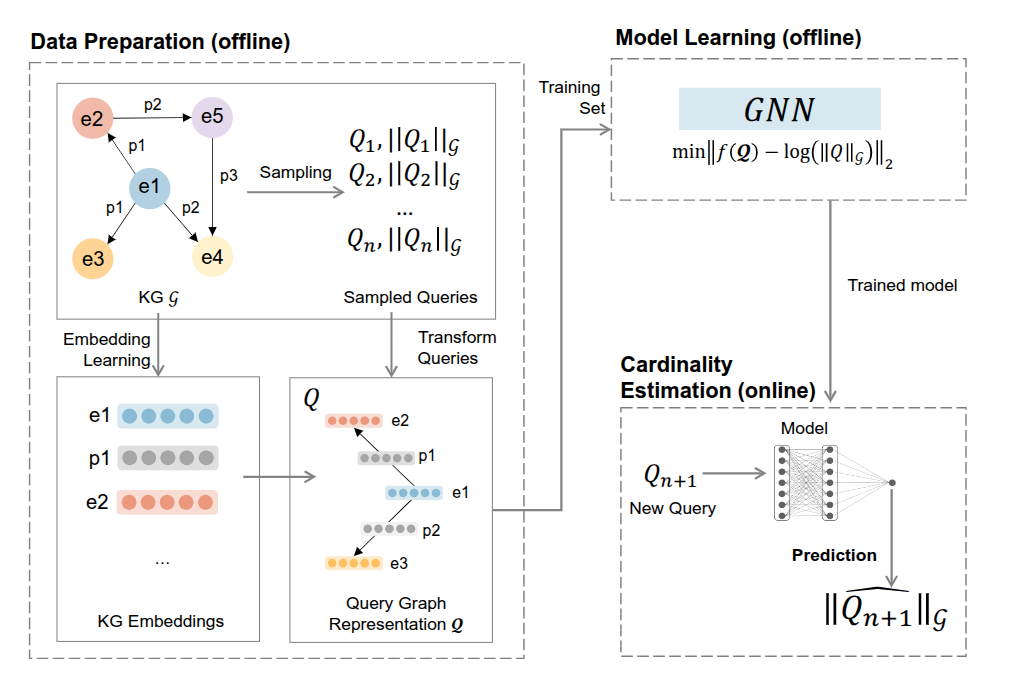

In [1]:
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from pyrdf2vec.embedders import Word2Vec
import json
import os
import pickle
import numpy as np
from tqdm import tqdm
from cardinality_estimation import train_GNCE


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



/home/tim/GNCE/.venv/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/tim/GNCE/.venv/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZNK3c105Error4whatEv
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/tim/GNCE/.venv/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/tim/GNCE/.venv/lib/python3.11/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


## Data Exploration

As our Knowledge Graph today, we use Semantic Web Dog Food (SWDF), a scholarly KG with papers, authors, citations etc. In total, the graph has 242256 triples, 76711 entities and 170 distinct predicates. 28% of the entities are typed,
with a total of 118 different classes.

For SPARQL queries over this graph, we are looking at **Star-shaped Queries.** I.e. queries with a central node and only outgoing edges from this node.

Lets load the queries and have a look at them:

In [2]:
with open('Datasets/swdf/star/Joined_Queries.json', 'r') as f:
   queries = json.load(f)

In [3]:
queries[0]

{'x': ['http://ex.org/01',
  'http://ex.org/1072',
  'http://ex.org/01',
  'http://ex.org/1074'],
 'y': 2,
 'query': ['SELECT * WHERE { ?s <http://ex.org/01> <http://ex.org/1072> . ?s <http://ex.org/01> <http://ex.org/1074> . }'],
 'triples': [['?s', '<http://ex.org/01>', '<http://ex.org/1072>', '.'],
  ['?s', '<http://ex.org/01>', '<http://ex.org/1074>', '.']]}

Each query here is a dict that holds the raw SPARQL query, the triples of the query, the entities and predicates occurring in the query and the true cardinality (y).

In [4]:
len(queries)

116645

In total, we do have ~116k queries.

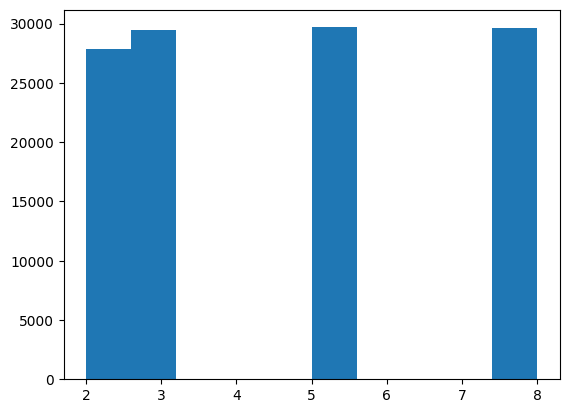

In [5]:
plt.hist([len(q['triples']) for q in queries])
plt.show()

We have queries with either 2,3,5 or 8 triple pattern, with a very balanced distribution.

## Embedding Learning


As the first step, we need to learn the embeddings for our entities. While there are many different KGE algorithms, we will use **RDF2Vec**. It encodes similarity and relatedness between entities, and a query consisiting of related 
entities should have a higher cardinality.
We will also calculate the **occurrence** for each entity and predicate, i.e. in how many triples it occurrs. This quantity is very cheap to obtain and serves as an upper bound for the cardinality ( as the upper bound is given by the cartesian product)

Lets first compute all the entities occurring in our queries, as we only need embeddings for those:

In [6]:
entities = []

for query in queries:
   entities += query['x']

entities = list(set(entities))
entities = entities[:]

print('Using ', len(entities), ' entities for RDF2Vec')

Using  11571  entities for RDF2Vec


Now we can start the learning procedure using pyrdf2vec. The approach first samples random walks from the swdf KG, and then learns embeddings using them. We will combine the embeddings with the occurrences into a single dict that we can later pass to the cardinality estimator learning pipeline

In [7]:
# We first define a KG object for pyrdf2vec
graph_file="Datasets/swdf/graph/swdf.nt"
kg = KG(graph_file, skip_verify=True)

# Next, we define the strategy with which we generate the random walks
walker = RandomWalker(max_depth=4, max_walks=10, with_reverse=False, n_jobs=24)

# And then define the word2vec model
embedder = Word2Vec(epochs=10, vector_size=100)

# Finally the full pipeline
model = RDF2VecTransformer(
    walkers=[walker],
    embedder=embedder,
    verbose=1,
)

# Now, we start the embedding learning, which will internally generate walks, learn embeddings and return them to us for the chosen entities
result = model.fit_transform(kg, entities)


# Extract embeddings from the tuple (embeddings, literals)
embeddings, literals = result

# Create entity-embedding mapping
embeddings_dict = {}
for i, entity in enumerate(entities):
    if i < len(embeddings):
        embeddings_dict[entity] = embeddings[i]
    else:
        embeddings_dict[entity] = []


# Calculate occurrences
print("Calculating occurrences...")
occurrences = {}
with open(graph_file, "r") as file:
    for line in tqdm(file):
        line = line.strip().split(" ")
        s = line[0].replace("<", "").replace(">", "")
        p = line[1].replace("<", "").replace(">", "")
        o = line[2].replace("<", "").replace(">", "")
        
        occurrences[s] = occurrences.get(s, 0) + 1
        occurrences[p] = occurrences.get(p, 0) + 1
        occurrences[o] = occurrences.get(o, 0) + 1

# Convert to JSON format with embeddings and occurrences
embeddings_dict_json = {}
for entity, embedding in embeddings_dict.items():
    embedding_list = embedding.tolist() if embedding is not None and hasattr(embedding, 'tolist') else embedding
    occurrence_count = occurrences.get(entity, 0)
    embeddings_dict_json[entity] = {"embedding": embedding_list, "occurence": occurrence_count}

with open("Datasets/swdf/swdf_embeddings.json", "w") as f:
    json.dump(embeddings_dict_json, f, indent=2)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11571/11571 [00:05<00:00, 2232.11it/s]


Extracted 85415 walks for 11571 entities (5.9149s)
Fitted 85415 walks (2.7700s)
Calculating occurrences...


242256it [00:00, 1099753.56it/s]


All embeddings have been learned, lets look at an example entry:

In [8]:
embeddings_dict_json['http://ex.org/25074']

{'embedding': [-0.023602329194545746,
  0.032325275242328644,
  0.014032723382115364,
  0.02462882362306118,
  0.01926528289914131,
  -0.11007680743932724,
  0.10524837672710419,
  0.2109355926513672,
  -0.05559727922081947,
  -0.1493014097213745,
  -0.0009884394239634275,
  -0.12464258074760437,
  0.028318965807557106,
  0.07488030195236206,
  0.033215925097465515,
  -0.06672825664281845,
  0.028946539387106895,
  -0.06250295788049698,
  -0.04310086369514465,
  -0.23989185690879822,
  0.08739925920963287,
  -0.002279141452163458,
  0.08823556452989578,
  -0.02632514014840126,
  -0.005700045730918646,
  -0.021230285987257957,
  -0.06273602694272995,
  0.020464686676859856,
  -0.0829271674156189,
  0.03901614993810654,
  0.05957436189055443,
  -0.04235411435365677,
  0.01993446983397007,
  -0.17498436570167542,
  -0.05546914413571358,
  0.07673614472150803,
  0.08771451562643051,
  0.052756417542696,
  -0.055676400661468506,
  -0.01879158429801464,
  0.049799829721450806,
  -0.109260208

**Exercise: Explain what you see here**

Lets further investigate the embeddings by projecting them to 2 dimensions and plotting them together with their rdf:type:

242256it [00:00, 1565726.31it/s]


Found 21811 entities with RDF types
Embedding matrix shape: (11571, 100)
Explanation: We have 11571 entities, each represented by 100-dimensional embeddings
Found 25 unique types: ['Unknown', 'http://ex.org/14033', 'http://ex.org/14890', 'http://ex.org/14895', 'http://ex.org/18539', 'http://ex.org/18543', 'http://ex.org/18552', 'http://ex.org/18561', 'http://ex.org/1961', 'http://ex.org/20360']...

Applying PCA for dimensionality reduction...
Applying t-SNE for dimensionality reduction...


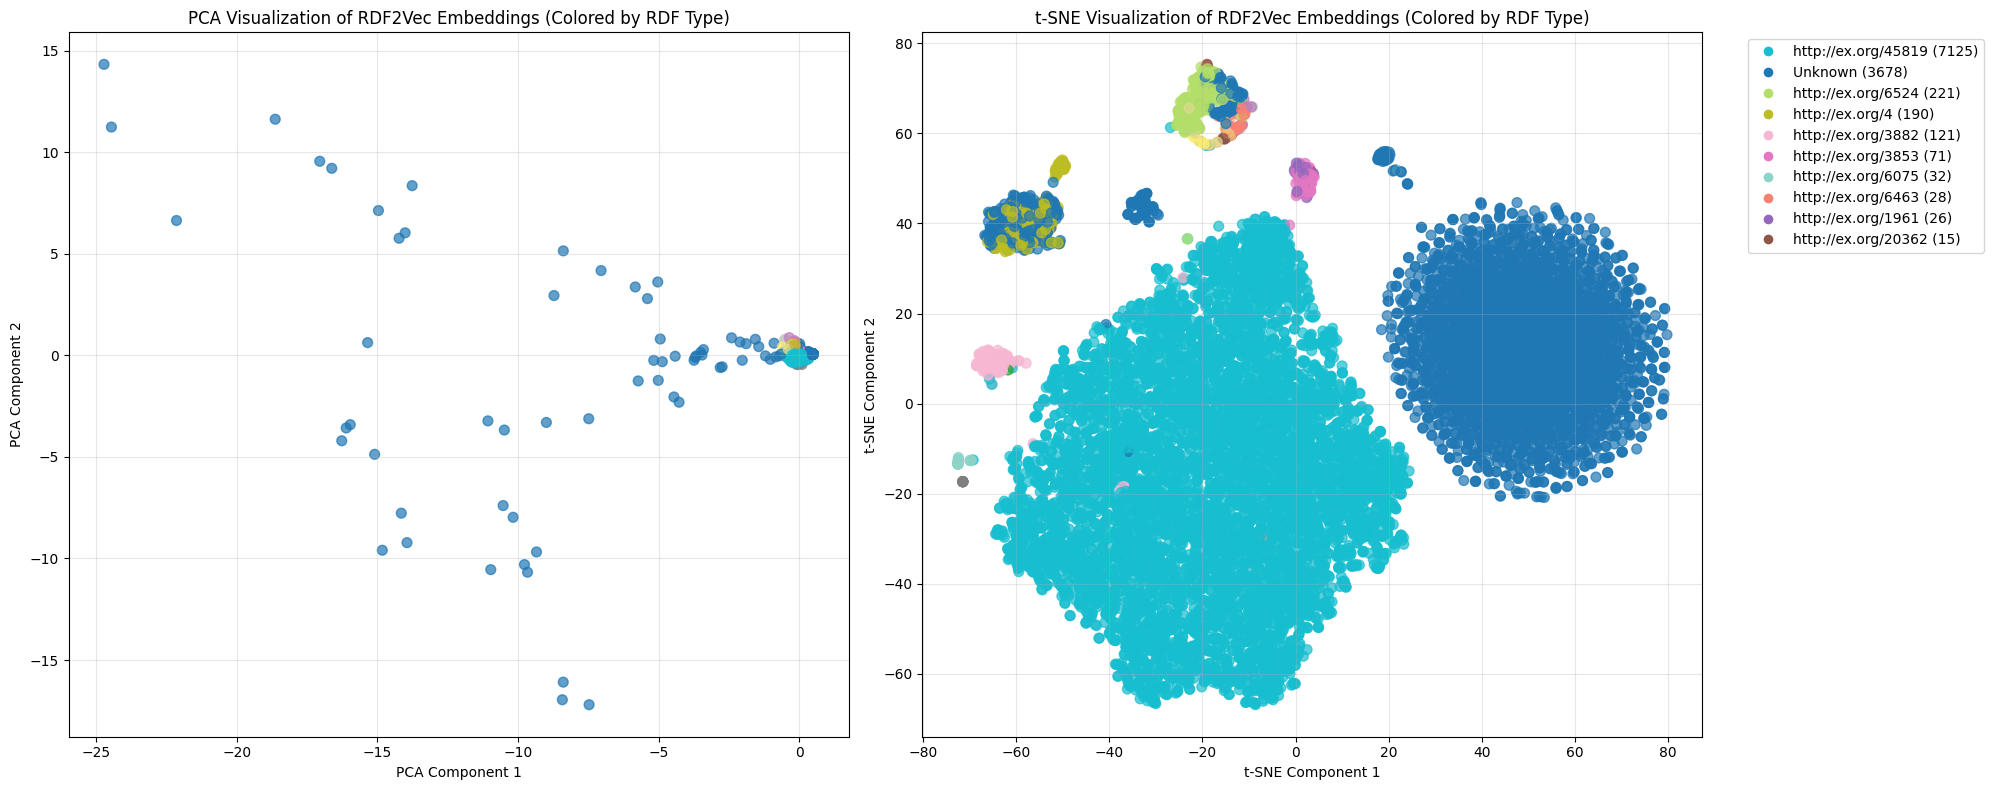


Visualization saved as 'embeddings_visualization.png'
Type distribution:
  http://ex.org/45819: 7125 entities
  Unknown: 3678 entities
  http://ex.org/6524: 221 entities
  http://ex.org/4: 190 entities
  http://ex.org/3882: 121 entities
  http://ex.org/3853: 71 entities
  http://ex.org/6075: 32 entities
  http://ex.org/6463: 28 entities
  http://ex.org/1961: 26 entities
  http://ex.org/20362: 15 entities


In [9]:
# Convert lists back to numpy arrays
embeddings_dict = {}
for entity, data in embeddings_dict_json.items():
    if data is not None and isinstance(data, dict) and "embedding" in data:
        embedding = data["embedding"]
        if embedding is not None and isinstance(embedding, list) and len(embedding) > 0:
            embeddings_dict[entity] = np.array(embedding)
        else:
            embeddings_dict[entity] = embedding
    else:
        embeddings_dict[entity] = data

# Load RDF types from .nt file
entity_types = {}
graph_file = "Datasets/swdf/graph/swdf.nt"

with open(graph_file, "r") as file:
    for line in tqdm(file):
        line = line.strip()
        if line.endswith(' .'):
            parts = line[:-2].split(' ', 2)
            if len(parts) == 3:
                subject = parts[0].strip('<>')
                predicate = parts[1].strip('<>')
                object_part = parts[2].strip('<>')
                
                # Check if this is an rdf:type triple
                if predicate == "http://ex.org/03":
                    entity_types[subject] = object_part

print(f"Found {len(entity_types)} entities with RDF types")

# Filter out any None or invalid embeddings
valid_entities = []
valid_embeddings = []

for entity, embedding in embeddings_dict.items():
    if embedding is not None and hasattr(embedding, 'shape') and embedding.shape[0] > 0:
        valid_entities.append(entity)
        valid_embeddings.append(embedding)

if not valid_embeddings:
    print("No valid embeddings found!")
    exit()

entity_names = valid_entities
embedding_matrix = np.vstack(valid_embeddings)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Explanation: We have {embedding_matrix.shape[0]} entities, each represented by {embedding_matrix.shape[1]}-dimensional embeddings")

# Create type mapping for entities with embeddings
entity_type_labels = []
unique_types = set()

for entity in entity_names:
    if entity in entity_types:
        entity_type_labels.append(entity_types[entity])
        unique_types.add(entity_types[entity])
    else:
        entity_type_labels.append("Unknown")
        unique_types.add("Unknown")

unique_types = sorted(list(unique_types))
print(f"Found {len(unique_types)} unique types: {unique_types[:10]}{'...' if len(unique_types) > 10 else ''}")

# Create color mapping
import matplotlib.cm as cm
colors = cm.tab20(np.linspace(0, 1, min(len(unique_types), 20)))
if len(unique_types) > 20:
    additional_colors = cm.Set3(np.linspace(0, 1, len(unique_types) - 20))
    colors = np.vstack([colors, additional_colors])

type_to_color = {type_name: colors[i] for i, type_name in enumerate(unique_types)}
entity_colors = [type_to_color[type_label] for type_label in entity_type_labels]

# Visualize embeddings in 2D using dimensionality reduction
# Method 1: PCA (Principal Component Analysis)
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embedding_matrix)

# Method 2: t-SNE (t-Distributed Stochastic Neighbor Embedding)
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(entity_names)-1))
embeddings_tsne = tsne.fit_transform(embedding_matrix)

# Create visualization for embeddings with type-based coloring
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA results
scatter1 = ax1.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                      c=entity_colors, alpha=0.7, s=50)
ax1.set_title('PCA Visualization of RDF2Vec Embeddings (Colored by RDF Type)')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.grid(True, alpha=0.3)

# Plot t-SNE results  
scatter2 = ax2.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                      c=entity_colors, alpha=0.7, s=50)
ax2.set_title('t-SNE Visualization of RDF2Vec Embeddings (Colored by RDF Type)')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.grid(True, alpha=0.3)


type_counts = {}
for type_label in entity_type_labels:
    type_counts[type_label] = type_counts.get(type_label, 0) + 1

# Sort types by frequency and take top 10
top_types = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create legend handles
legend_elements = []
for type_name, count in top_types:
    color = type_to_color[type_name]
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color, markersize=8, 
                                    label=f'{type_name} ({count})'))

# Add legend to the right of the second subplot
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('embeddings_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved as 'embeddings_visualization.png'")
print(f"Type distribution:")
for type_name, count in top_types:
    print(f"  {type_name}: {count} entities")

**Exercise : Explain the results here and what they do mean**

## Cardinality Estimator GNN Training

Now that we have the embeddings and occurrences in place, we can start training our GNN. The figure below shows the GNN architecture used in GNCE:

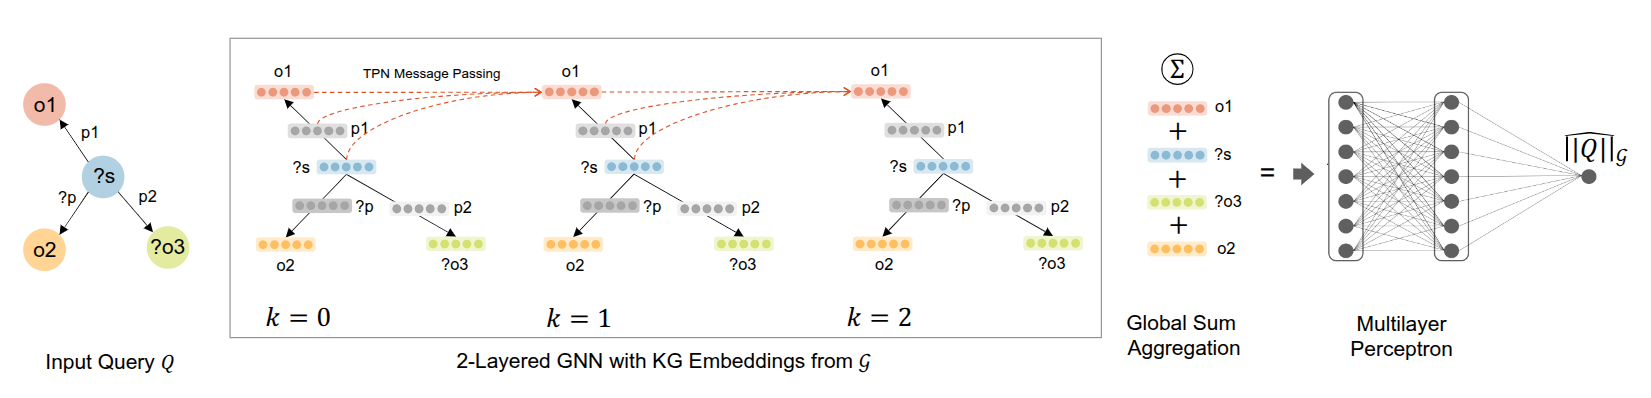

The graph of the initial query is first transformed by attaching the learned KGE to the nodes and edges $(k=0)$. This graph is then processed by 2 **message-passing layers** $(k=1,2)$. These pass and transform information between the nodes, so that the representation vectors of the nodes encode the local neighborhood and structure.


Then, the final representation of all nodes are aggregated using summation, which results in a single vector. Lastly, this vector is transformed by a 2-layer MLP into a single scalar, which represents the predicted cardinality of the query.

Lets start by defining some flags for the training:

In [44]:
starttime = 'TEST' # Folder Name
query_filename = "Joined_Queries.json" # Name of the query file
dataset = 'swdf' # Dataset Name
query_type = 'star' # type of queries we look at
DATASET_PATH = 'Datasets/' # where the dataset and queries are stored

N_TRAIN_QUERIES = 100 # on how many queries to train
N_TEST_QUERIES = 1000 # on how many queries to test
EPOCHS = 5 # how many times we loop over the queries during training

# This flag denotes whether we use the KGE embeddings or binary embeddings where the embedding for an entity is just the binary representation of its id padded to 100 dimensions with 0s
random_embeddings = False

# This flag denotes whether we include the occurrence value into the representation or not
use_occurrence = True



In [45]:
max_occurrence = max(item['occurence'] for item in embeddings_dict_json.values())

We use the `train_GNCE` function that is provided by this repository. Internally, it loads the queries from the provided file, loads the embeddings and transforms the queries to graphs with embeddings as features.
It then train the Cardinality Estimation GNN on the first `N_TRAIN_QUERIES`and evaluates on the last `N_TEST_QUERIES`. 

Lets train it.

In [46]:
n_atoms, start_time_gnce,  end_time_gnce, preds, gts, sizes = train_GNCE(dataset=dataset, query_type=query_type, query_filename=query_filename, eval_folder=starttime
                                                                         , DATASETPATH=DATASET_PATH, n_train_queries=N_TRAIN_QUERIES, n_test_queries=N_TEST_QUERIES, epochs=EPOCHS, random_embeddings=random_embeddings, use_occurrence=use_occurrence, max_occurrence=max_occurrence)


Using Device:  cpu
Successfully loaded statistics
Training on:  100  queries
Evaluating on:  1000  queries
Starting Training...
Number of Parameters:  122513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 770.06it/s]


Epoch 0, Train Loss: 5.973533019644893, Avg Train Q-Error: 61.18055069901281


 20%|█████████████████████████████████████████████████▍                                                                                                                                                                                                     | 1/5 [00:01<00:05,  1.36s/it]

MAE:  183.7606183846076
Qerror:  154.4001225834731
Time taken for one epoch: -1756180525910.6475 seconds
New smallest Q-Error, saving model and statistics



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.47it/s]


Epoch 1, Train Loss: 5.7077711639715565, Avg Train Q-Error: 55.123310653731465


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 2/5 [00:02<00:04,  1.48s/it]

MAE:  183.74690332306957
Qerror:  139.19910422259443
Time taken for one epoch: -1756180527271.8928 seconds
New smallest Q-Error, saving model and statistics



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.27it/s]


Epoch 2, Train Loss: 5.44143728754794, Avg Train Q-Error: 49.3875690457225


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 3/5 [00:04<00:03,  1.52s/it]

MAE:  183.7306185603643
Qerror:  124.5264321436211
Time taken for one epoch: -1756180528840.5715 seconds
New smallest Q-Error, saving model and statistics



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 339.33it/s]


Epoch 3, Train Loss: 5.166287135461091, Avg Train Q-Error: 43.96421349964329


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4/5 [00:06<00:01,  1.52s/it]

MAE:  183.70745352108733
Qerror:  108.91908275735116
Time taken for one epoch: -1756180530398.4265 seconds
New smallest Q-Error, saving model and statistics



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.54it/s]


Epoch 4, Train Loss: 4.852428603734989, Avg Train Q-Error: 38.24592387423914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]

MAE:  183.6737842922011
Qerror:  92.73539537521006
Time taken for one epoch: -1756180531923.9536 seconds
New smallest Q-Error, saving model and statistics


Mean Absolute Error:  183.67336415018138
Mean Q-Error:  96.05446499760465
Mean execution time:  1.210170030593872
Mean execution time total:  3.1053316593170166


Great, the training is finished. During Training, we already saw some metrics being printed out. The function returns multiple things, but important to us are preds, gts and sizes.
preds is an array of cardinality predictions for the test queries, gts are the true cardinalities for the queries, and sizes contains the sizes (number of triple patterns) of the respective queries.

## Analysis of the Cardinality Estimator Training

Lets now investigate how well the training went. Lets first look at the raw predictions compared to the true cardinalities in a scatter plot:

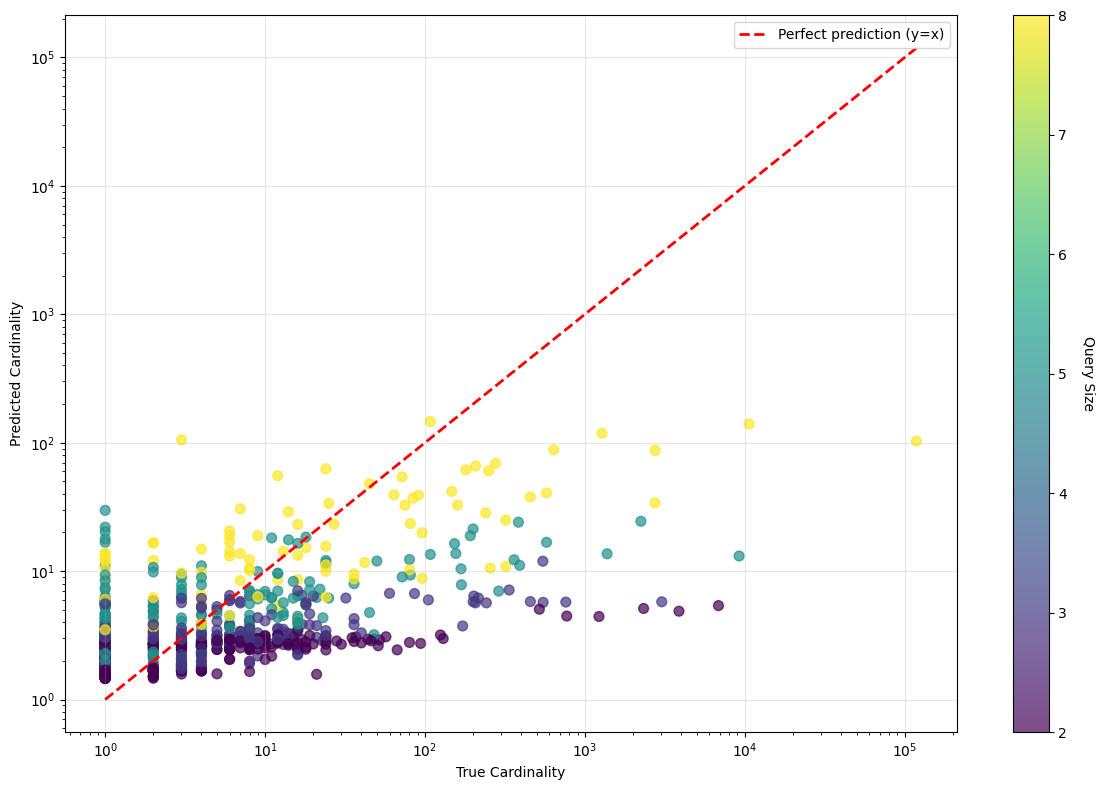

In [19]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(gts, preds, c=sizes, alpha=0.7, s=50, cmap='viridis')

# Add colorbar to show size mapping
cbar = plt.colorbar(scatter)
cbar.set_label('Query Size', rotation=270, labelpad=20)

# Add perfect prediction line (y=x)
min_val = min(min(gts), min(preds))
max_val = max(max(gts), max(preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction (y=x)')

plt.xlabel('True Cardinality')
plt.ylabel('Predicted Cardinality')
plt.legend()
plt.grid(True, alpha=0.3)

if max_val / min_val > 100:
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

**Exercise 1: Interpret the results**

..............

Lets now try to quantify how well the training worked. There are several suitable metrics to compare predicted real numbers to the target value. In cardinality estimation, the so called Q-Error is most often used. It is defined as

$\mathcal{L}(true, pred) = max(\frac{true}{pred}, \frac{pred}{true})$

I.e. a perfect prediction would yield a q-error of 1. The q-Error is commonly used in cardinality estimation, because it is **scale-invariant**. E.g. if you predict $10^9$ instead of $10^8$, the q-error is 10, the same as if you predicted 100 instead of 10. This makes sure that the same relative errors in smaller cardinality regimes are weighted the same as equivalent errors for larger cardinalities.

Further, an error of 100 is much worse if the true cardinality is 200 than if it would have been e.g. $10^8$.

Lets calculate the mean q-Error for our predictions:

In [20]:
preds = np.array(preds)
gts = np.array(gts)

# Filter out cases where ground truth (they shouldnt be in the dataset, but we make sure) is 0 to avoid division by zero
valid_mask = gts > 0
valid_preds = preds[valid_mask]
valid_gts = gts[valid_mask]

q_errors = np.maximum(valid_preds / valid_gts, valid_gts / valid_preds)
mean_q_error = np.mean(q_errors)
median_q_error = np.median(q_errors)

print(f"Q-error statistics:")
print(f"  Mean Q-error: {mean_q_error:.4f}")
print(f"  Median Q-error: {median_q_error:.4f}")
print(f"  Min Q-error: {np.min(q_errors):.4f}")
print(f"  Max Q-error: {np.max(q_errors):.4f}")

Q-error statistics:
  Mean Q-error: 9.7014
  Median Q-error: 1.9066
  Min Q-error: 1.0012
  Max Q-error: 1270.9447


**Exercise 2: Interpret the results !**

..............

Great ! Lastly, we would like to know how the q-Error behaves for different query-sizes to have a more nuanced understanding.

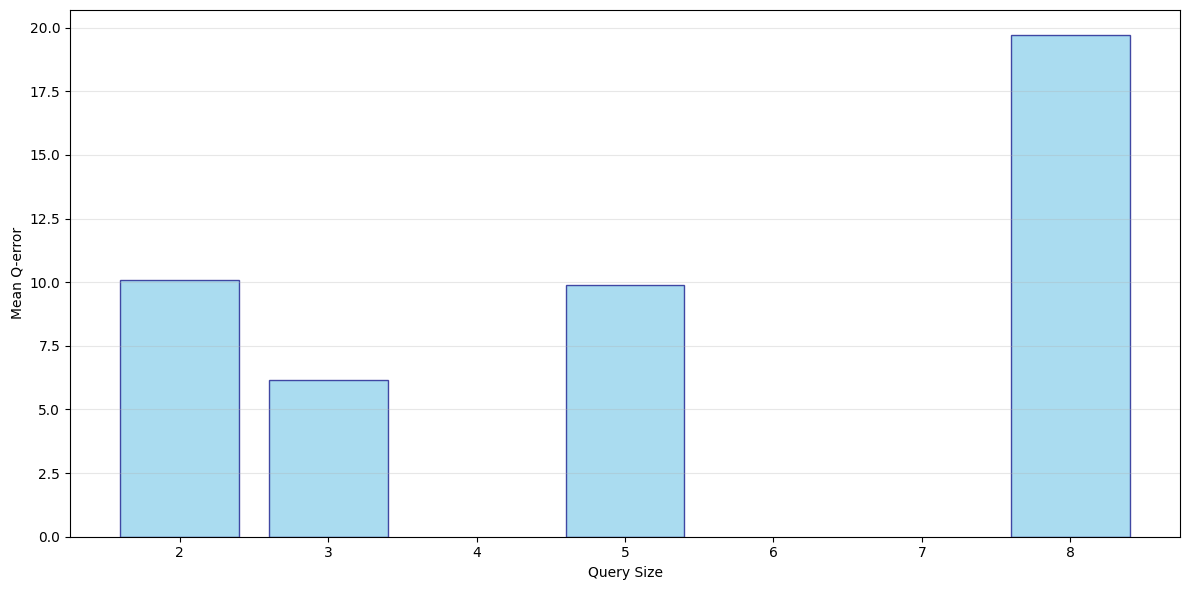

In [21]:
# We first need to calculate the different sizes appearing
unique_sizes = np.unique(sizes)

mean_q_errors_per_size = []
query_counts_per_size = []

for size in unique_sizes:
    # Get indices where the size matches and ground truth > 0
    size_mask = (sizes == size) & (gts > 0)
    size_indices = np.where(size_mask)[0]
    
    # Get corresponding q-errors (need to map back to the filtered q_errors array)
    valid_indices = np.where(valid_mask)[0]
    q_error_indices = np.isin(valid_indices, size_indices)
    
    if np.any(q_error_indices):
        size_q_errors = q_errors[q_error_indices]
        mean_q_errors_per_size.append(np.mean(size_q_errors))
        query_counts_per_size.append(len(size_q_errors))
    else:
        mean_q_errors_per_size.append(0)
        query_counts_per_size.append(0)

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_sizes, mean_q_errors_per_size, alpha=0.7, color='skyblue', edgecolor='navy')

plt.xlabel('Query Size')
plt.ylabel('Mean Q-error')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
               

**Exercise 3: Interpret the results**

............

**Exercise 4: Investigate the behavior of different training parameters**

Now, after having gone through the embedding generation and the training and evaluation of the cardinality estimator, your task is to investigate how different aspects of the training influence the validation q-error. For that,
investigate how the following three hyperparameters influence the training:
1. Number of Training Queries (e.g. 100, 1000,10000)
2. Number of Training Epochs (e.g. 1 to 10)

The goal is to produce a plot with the hyperparameter on the x-axis and the mean q-error on the y-axis.

**Exercise 5: Effect of Embeddings and Occurrence**

How does using binary embeddings instead of KGE change the performance of the cardinality estimator ? Which effect does removing the occurrence have ? Is there a certain number of training queries you need to use in order to see an effect ?